# Simple Grid Chain

In [10]:
import random

import matplotlib.pyplot as plt
from functools import partial
import networkx as nx

from gerrychain import MarkovChain
from gerrychain.constraints import (
    Validator,
    single_flip_contiguous,
    within_percent_of_ideal_population,
)
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap


## Setting up the initial partition

### Create graph

In [11]:
gn = 6
k = 5
ns = 50
p = 0.5

graph = nx.grid_graph([k * gn, k * gn])


for n in graph.nodes():
    graph.node[n]["population"] = 1

    if random.random() < p:
        graph.node[n]["pink"] = 1
        graph.node[n]["purple"] = 0
    else:
        graph.node[n]["pink"] = 0
        graph.node[n]["purple"] = 1
    if 0 in n or k * gn - 1 in n:
        graph.node[n]["boundary_node"] = True
        graph.node[n]["boundary_perim"] = 1

    else:
        graph.node[n]["boundary_node"] = False

# this part adds queen adjacency
# for i in range(k*gn-1):
#    for j in range(k*gn):
#        if j<(k*gn-1):
#            graph.add_edge((i,j),(i+1,j+1))
#            graph[(i,j)][(i+1,j+1)]["shared_perim"]=0
#        if j >0:
#            graph.add_edge((i,j),(i+1,j-1))
#            graph[(i,j)][(i+1,j-1)]["shared_perim"]=0

### Build assignment

In [12]:
cddict = {x: int(x[0] / gn) for x in graph.nodes()}

### Plot grids

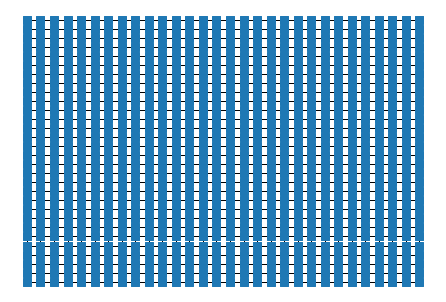

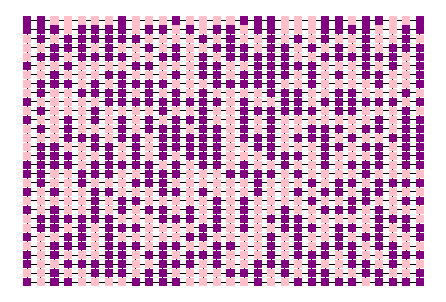

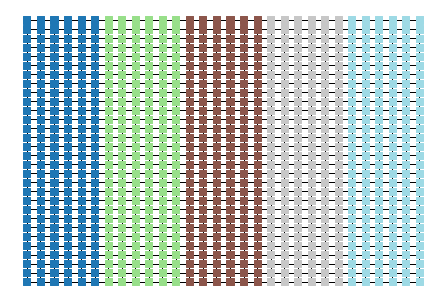

In [13]:
plt.figure()
nx.draw(graph, pos={x: x for x in graph.nodes()}, node_size=ns, node_shape="s")
plt.show()

cdict = {1: "pink", 0: "purple"}

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cdict[graph.node[x]["pink"]] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
)
plt.show()

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[cddict[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
    cmap="tab20",
)
plt.show()

### Configure updaters

In [14]:
def step_num(partition):
    parent = partition.parent
    if not parent:
        return 0
    return parent["step_num"] + 1


updaters = {
    "population": Tally("population"),
    "cut_edges": cut_edges,
    "step_num": step_num,
    "Pink-Purple": Election("Pink-Purple", {"Pink": "pink", "Purple": "purple"}),
}

### Build Partition

In [15]:
grid_partition = Partition(graph, assignment=cddict, updaters=updaters)

## Setting up our Markov chains

### Constraints

In [16]:
popbound = within_percent_of_ideal_population(grid_partition, 0.1)

### Proposal function

In [17]:
ideal_population = sum(grid_partition["population"].values()) / len(grid_partition)

tree_proposal = partial(
    recom,
    pop_col="population",
    pop_target=ideal_population,
    epsilon=0.05,
    node_repeats=1,
)

## Create the Markov chains

In [18]:
recom_chain = MarkovChain(
    tree_proposal,
    Validator([popbound]),
    accept=always_accept,
    initial_state=grid_partition,
    total_steps=100,
)

boundary_chain = MarkovChain(
    propose_random_flip,
    Validator([single_flip_contiguous, popbound]),
    accept=always_accept,
    initial_state=grid_partition,
    total_steps=10000,
)

## Run Markov chains

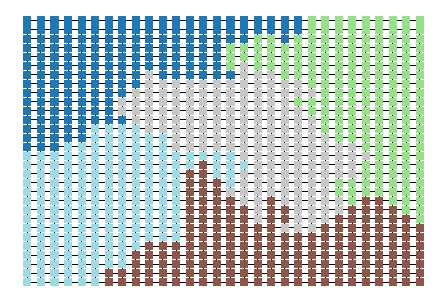

In [19]:
rsw = []
rmm = []
reg = []
rce = []

for part in recom_chain:
    rsw.append(part["Pink-Purple"].wins("Pink"))
    rmm.append(mean_median(part["Pink-Purple"]))
    reg.append(efficiency_gap(part["Pink-Purple"]))
    rce.append(len(part["cut_edges"]))
    # plt.figure()
    # nx.draw(
    #     graph,
    #     pos={x: x for x in graph.nodes()},
    #     node_color=[dict(part.assignment)[x] for x in graph.nodes()],
    #     node_size=ns,
    #     node_shape="s",
    #     cmap="tab20",
    # )
    # plt.savefig(f"./Figures/recom_{part['step_num']:02d}.png")
    # plt.close()

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[dict(part.assignment)[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
    cmap="tab20",
)
plt.show()


bsw = []
bmm = []
beg = []
bce = []

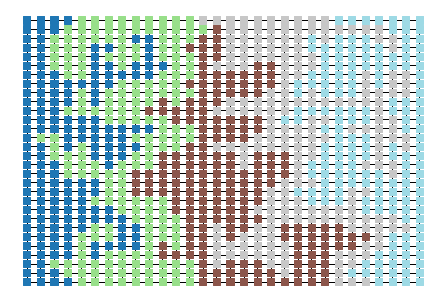

In [20]:
for part in boundary_chain:
    bsw.append(part["Pink-Purple"].wins("Pink"))
    bmm.append(mean_median(part["Pink-Purple"]))
    beg.append(efficiency_gap(part["Pink-Purple"]))
    bce.append(len(part["cut_edges"]))
    # plt.figure()
    # nx.draw(
    #     graph,
    #     pos={x: x for x in graph.nodes()},
    #     node_color=[dict(part.assignment)[x] for x in graph.nodes()],
    #     node_size=ns,
    #     node_shape="s",
    #     cmap="tab20",
    # )
    # plt.savefig(f"./Figures/boundary_{part['step_num']:04d}.png")
    # plt.close()

plt.figure()
nx.draw(
    graph,
    pos={x: x for x in graph.nodes()},
    node_color=[dict(part.assignment)[x] for x in graph.nodes()],
    node_size=ns,
    node_shape="s",
    cmap="tab20",
)
plt.show()

## Partisan plots

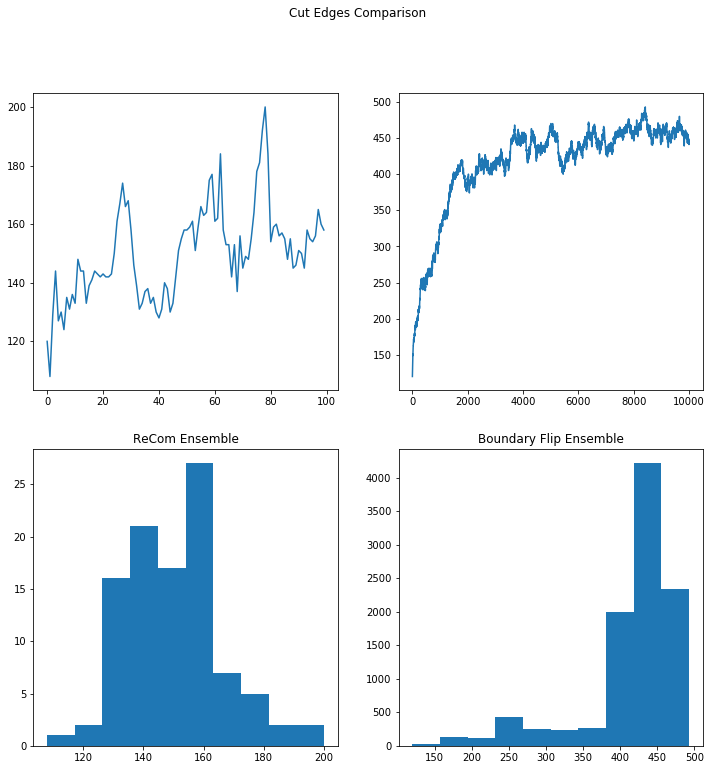

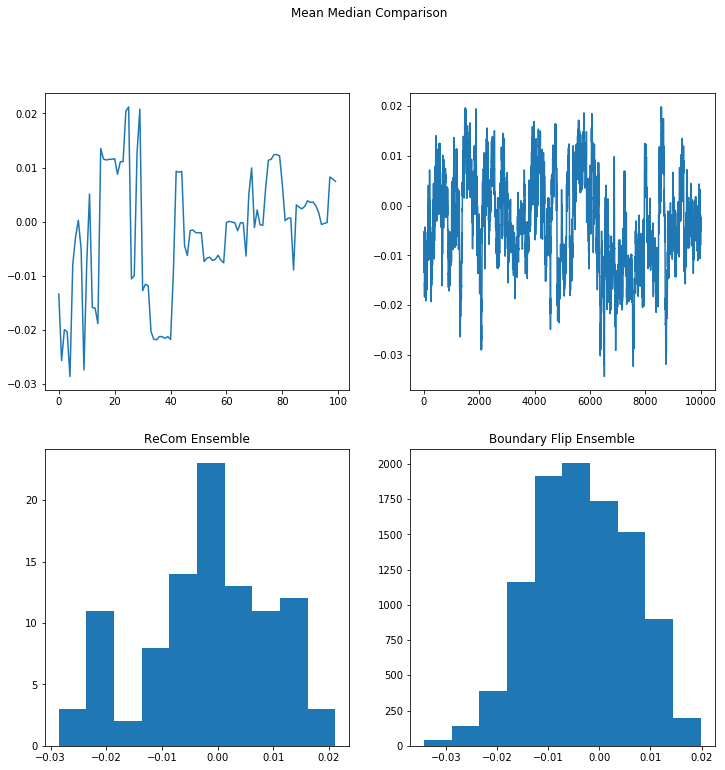

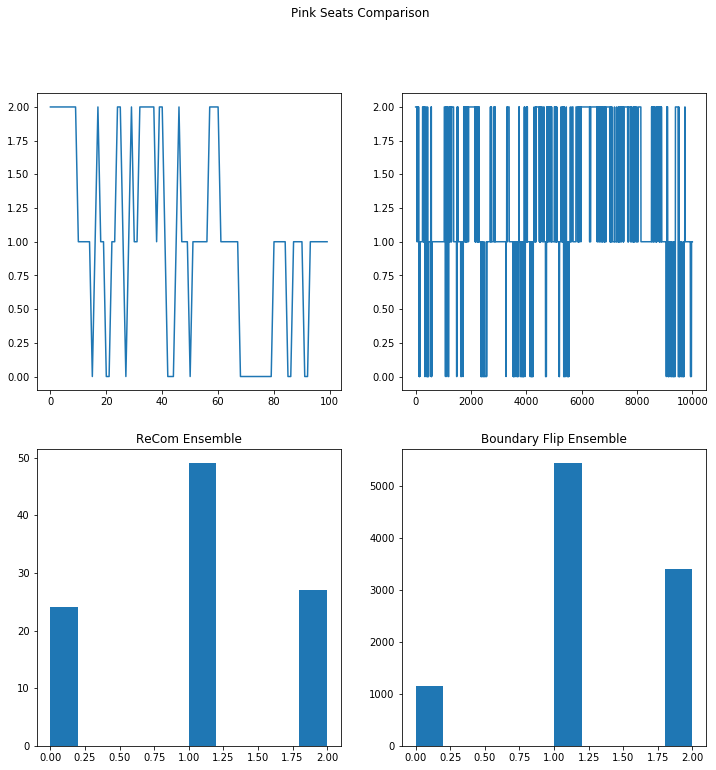

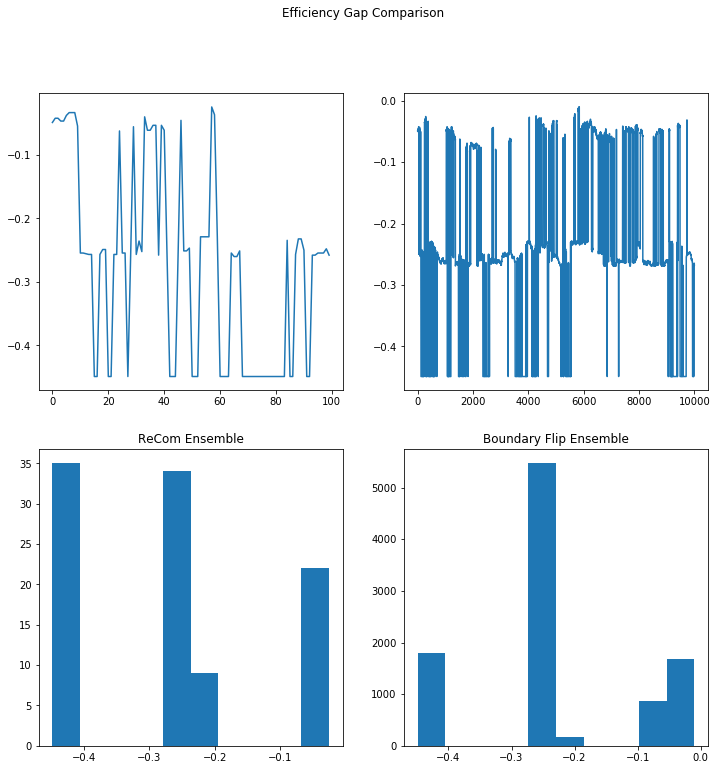

In [26]:
names = ["Cut Edges", "Mean Median", "Pink Seats", "Efficiency Gap"]
lists = [[rce, bce], [rmm, bmm], [rsw, bsw], [reg, beg]]


for z in range(4):
    plt.figure(figsize=(12,12))
    plt.suptitle(f"{names[z]} Comparison")

    plt.subplot(2, 2, 1)
    plt.plot(lists[z][0])

    plt.subplot(2, 2, 3)
    plt.hist(lists[z][0])
    plt.title("ReCom Ensemble")

    plt.subplot(2, 2, 2)
    plt.plot(lists[z][1])

    plt.subplot(2, 2, 4)
    plt.hist(lists[z][1])
    plt.title("Boundary Flip Ensemble")

    plt.show()